# Lab 7 Report:
## MNIST Generation with DCGAN

### Name: Min-Hao (Mike) Huang

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import pandas as pd
import seaborn as sns

In [2]:
# fix file path in google colab
from google.colab import drive
drive.mount('/content/drive')

# change path
import os
os.chdir('/content/drive/MyDrive/Lab7_Template')

Mounted at /content/drive


In [3]:
from IPython.display import Image # For displaying images in colab jupyter cell

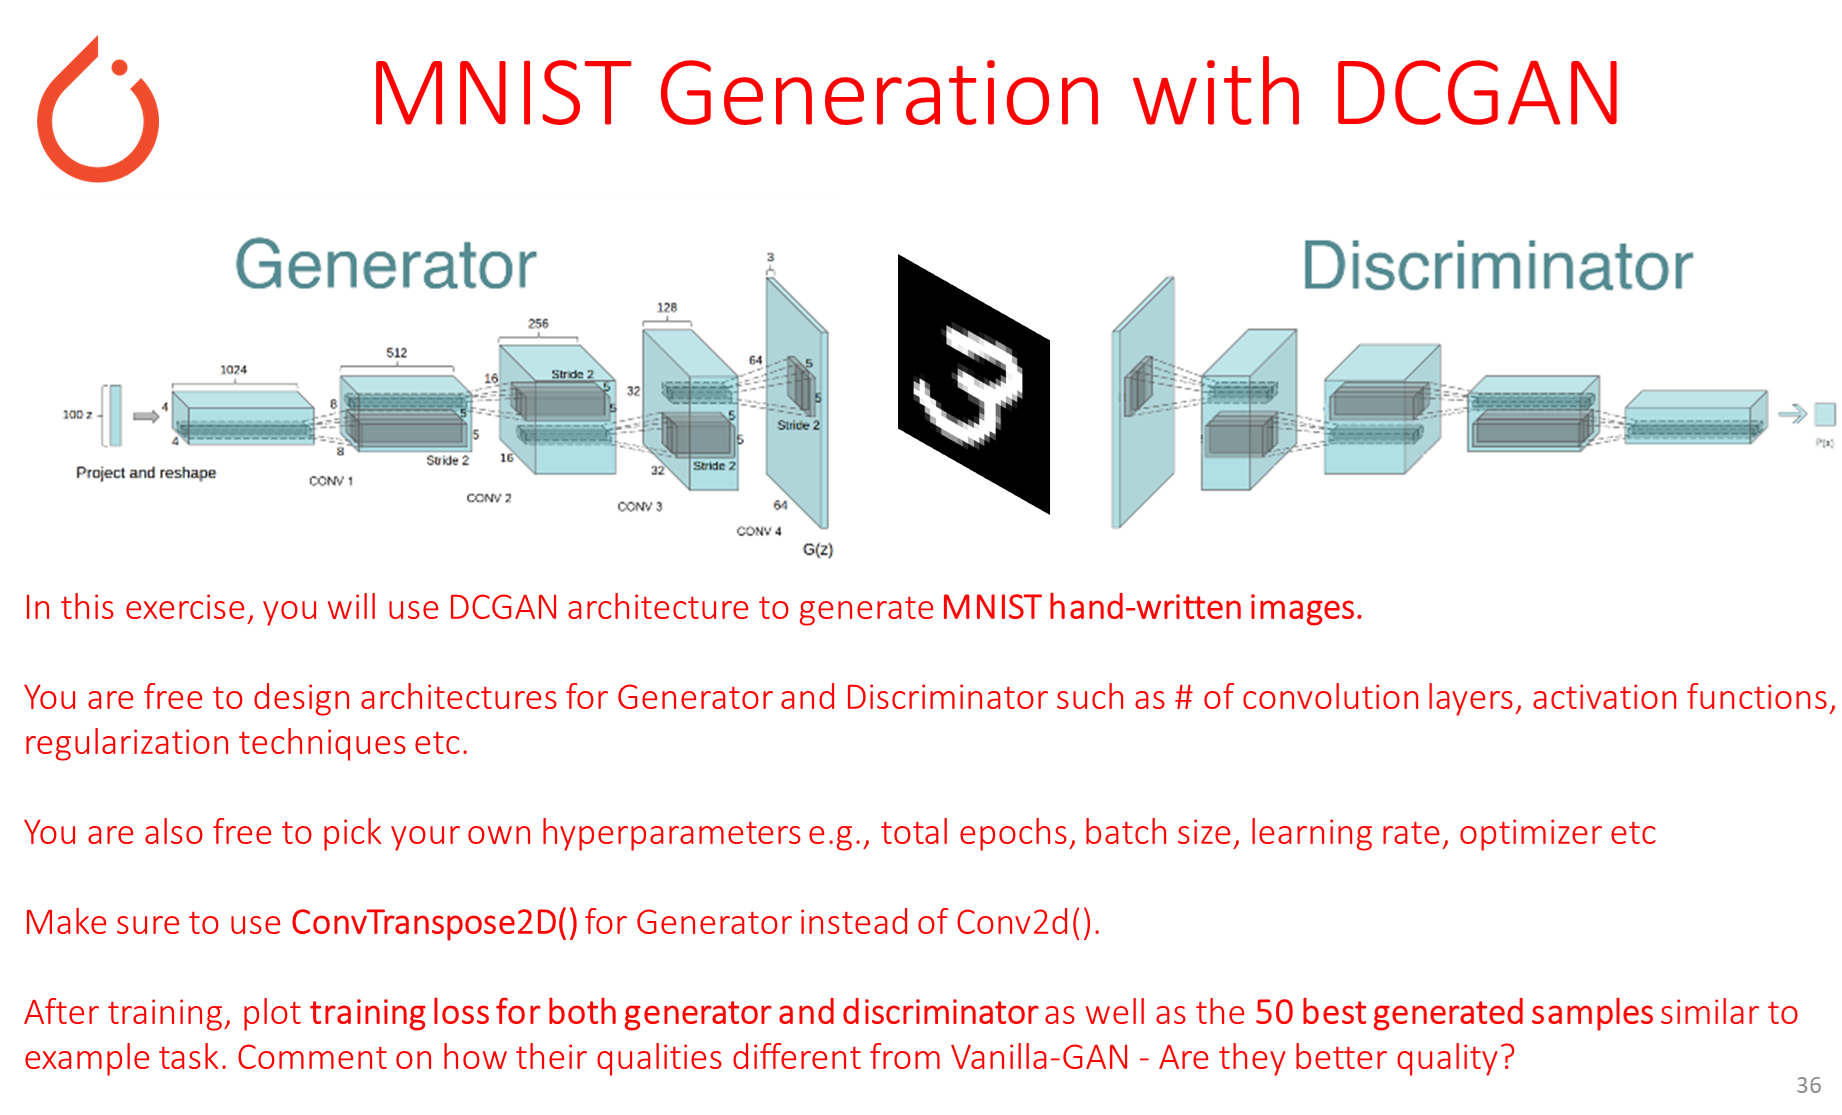

In [4]:
Image('lab7_exercise.png', width = 1000)

In [5]:
# Seaborn plot styling
sns.set(style = 'white', font_scale = 2)

## Prepare Data

In [6]:
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from torchvision import transforms

# Define a transformation to convert the data into Tensors
train_transforms = transforms.Compose([transforms.ToTensor()])

# Download the train and test MNIST data and transform it into Tensors
train_data = MNIST(root="./train.", train=True, download=True, transform=train_transforms)

## Define Model

In [96]:
class Generator(torch.nn.Module):

    def __init__(self, batchsize, input_noise_dim):

        super(Generator, self).__init__()

        self.batchsize = batchsize  # Batch size for input data
        self.input_noise_dim = input_noise_dim  # Dimension of the input data

        self.fc1 = torch.nn.Linear(input_noise_dim, 128)  # Fully connected layer 1
        self.LReLU = torch.nn.LeakyReLU()  # Leaky ReLU activation function
        self.fc2 = torch.nn.Linear(128, 1 * 28 * 28)  # Fully connected layer 2
        self.output = torch.nn.Tanh()  # Hyperbolic Tangent activation function

    def forward(self, x):

        layer1 = self.LReLU(self.fc1(x))  # Apply Leaky ReLU to the first fully connected layer
        layer2 = self.output(self.fc2(layer1))  # Apply Tanh to the second fully connected layer
        out = layer2.view(self.batchsize, 1, 28, 28)  # Reshape the output to match image dimensions

        return out

class Discriminator(torch.nn.Module):

    def __init__(self, batchsize):

        super(Discriminator, self).__init__()

        self.batchsize = batchsize  # Batch size for input data

        self.fc1 = torch.nn.Linear(1 * 28 * 28, 128)  # Fully connected layer 1
        self.LReLU = torch.nn.LeakyReLU()  # Leaky ReLU activation function
        self.fc2 = torch.nn.Linear(128, 1)  # Fully connected layer 2
        self.output = torch.nn.Sigmoid()  # Sigmoid activation function

    # Function for forward propagation
    def forward(self, x):

        flat = x.view(self.batchsize, -1)  # Flatten the input image
        layer1 = self.LReLU(self.fc1(flat))  # Apply Leaky ReLU to the first fully connected layer
        out = self.output(self.fc2(layer1))  # Apply Sigmoid to the second fully connected layer

        return out.view(-1, 1).squeeze(1)  # Flatten the output and remove unnecessary dimension

## Define Hyperparameters

In [97]:
# device
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)

cuda


In [98]:
# Fix random seed
torch.manual_seed(55)

# Define learning rate + epochs
learning_rate = 1e-4
epochs = 10
feature_maps_gen = 64
feature_maps_disc = 64
num_channels = 1

# Define batch size and num_features/timestep (this is simply the last dimension of train_output_seqs)
batchsize = 128
input_noise_dim = 100

# Create a Discriminator model
disc = Discriminator(batchsize)
gen = Generator(batchsize, input_noise_dim)
# gen = Generator(input_noise_dim, feature_maps_gen, num_channels).to(device)
# disc = Discriminator(feature_maps_disc, num_channels).to(device)
# disc = Discriminator(input_channels=1, hidden_dim=64).to(device)



# Binary Cross Entropy (BCE) loss function
loss_func = nn.BCELoss()
optimizer_disc = optim.Adam(disc.parameters(), lr=learning_rate, weight_decay=1e-05)
optimizer_gen = optim.Adam(gen.parameters(), lr=learning_rate, weight_decay=1e-05)


In [99]:
disc.to(device)

Discriminator(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (LReLU): LeakyReLU(negative_slope=0.01)
  (fc2): Linear(in_features=128, out_features=1, bias=True)
  (output): Sigmoid()
)

In [100]:
gen.to(device)

Generator(
  (fc1): Linear(in_features=100, out_features=128, bias=True)
  (LReLU): LeakyReLU(negative_slope=0.01)
  (fc2): Linear(in_features=128, out_features=784, bias=True)
  (output): Tanh()
)

## Identify Tracked Values

In [101]:
gen_train_loss_list = []
disc_train_loss_list = []

## Train Model

In [102]:
# Create DataLoader objects to efficiently load the training and test data in batches
train_loader = DataLoader(train_data, batch_size=batchsize, shuffle=False, drop_last=True)

In [103]:
from tqdm import tqdm

# Set the device as CUDA or CPU based on availability
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Run training for each epoch
for epoch in range(epochs):
    # print('Epoch {}/{}'.format(epoch + 1, epochs))

    running_loss_D = 0
    running_loss_G = 0

    # Wrap train_loader with tqdm to display the progress bar
    for inputs, labels in tqdm(train_loader, desc=f"Training Epoch {epoch}/{epochs}"):

        inputs = inputs.to(device)

        # Convert labels into torch tensors with the proper size as per the batch size
        real_label = torch.full((batchsize,), 1, dtype=inputs.dtype, device=device)
        fake_label = torch.full((batchsize,), 0, dtype=inputs.dtype, device=device)

        # Train Discriminator ---------------------------------------------------------------------------------------

        # Zero the gradients of the Discriminator optimizer
        optimizer_disc.zero_grad()

        # Compute output from the Discriminator
        output = disc(inputs)

        # Discriminator real loss
        D_real_loss = loss_func(output, real_label)
        D_real_loss.backward()

        # Generate random noise data as input to the Generator
        noise = torch.randn(batchsize, input_noise_dim, device=device)

        # Generate fake images using the Generator
        fake = gen(noise)

        # Pass fake images through the Discriminator with gradient detachment
        output = disc(fake.detach())

        # Discriminator fake loss
        D_fake_loss = loss_func(output, fake_label)
        D_fake_loss.backward()

        # Total loss for the Discriminator
        Disc_loss = D_real_loss + D_fake_loss
        running_loss_D += Disc_loss.item()

        # Update Discriminator's parameters
        optimizer_disc.step()

        # Train Generator ------------------------------------------------------------------------------------------

        # Zero the gradients of the Generator optimizer
        optimizer_gen.zero_grad()

        # Pass fake images obtained from the Generator to the Discriminator
        output = disc(fake)

        # Calculate Generator loss by giving fake images as input but providing real labels
        Gen_loss = loss_func(output, real_label)
        running_loss_G += Gen_loss.item()

        # Backpropagation for the Generator
        Gen_loss.backward()

        # Update Generator's parameters
        optimizer_gen.step()

        disc_train_loss_list.append(Disc_loss.item())
        gen_train_loss_list.append(Gen_loss.item())

    # Print the losses for the current epoch
    print("Discriminator Loss : {:.4f}".format(running_loss_D))
    print("Generator Loss : {:.4f}".format(running_loss_G))




Training Epoch 0/10: 100%|██████████| 468/468 [00:09<00:00, 49.58it/s]


Discriminator Loss : 543.4823
Generator Loss : 374.3201


Training Epoch 1/10: 100%|██████████| 468/468 [00:08<00:00, 55.03it/s]


Discriminator Loss : 602.6964
Generator Loss : 407.8401


Training Epoch 2/10: 100%|██████████| 468/468 [00:09<00:00, 49.40it/s]


Discriminator Loss : 515.8468
Generator Loss : 428.2332


Training Epoch 3/10: 100%|██████████| 468/468 [00:09<00:00, 49.07it/s]


Discriminator Loss : 497.5354
Generator Loss : 367.1105


Training Epoch 4/10: 100%|██████████| 468/468 [00:08<00:00, 54.12it/s]


Discriminator Loss : 506.4491
Generator Loss : 407.2191


Training Epoch 5/10: 100%|██████████| 468/468 [00:09<00:00, 50.12it/s]


Discriminator Loss : 532.1372
Generator Loss : 399.6902


Training Epoch 6/10: 100%|██████████| 468/468 [00:09<00:00, 49.07it/s]


Discriminator Loss : 480.3601
Generator Loss : 469.0317


Training Epoch 7/10: 100%|██████████| 468/468 [00:08<00:00, 53.74it/s]


Discriminator Loss : 446.6639
Generator Loss : 461.8594


Training Epoch 8/10: 100%|██████████| 468/468 [00:09<00:00, 50.82it/s]


Discriminator Loss : 460.9609
Generator Loss : 481.6543


Training Epoch 9/10: 100%|██████████| 468/468 [00:09<00:00, 48.93it/s]

Discriminator Loss : 443.1882
Generator Loss : 498.4837


## Visualize & Evaluate Model

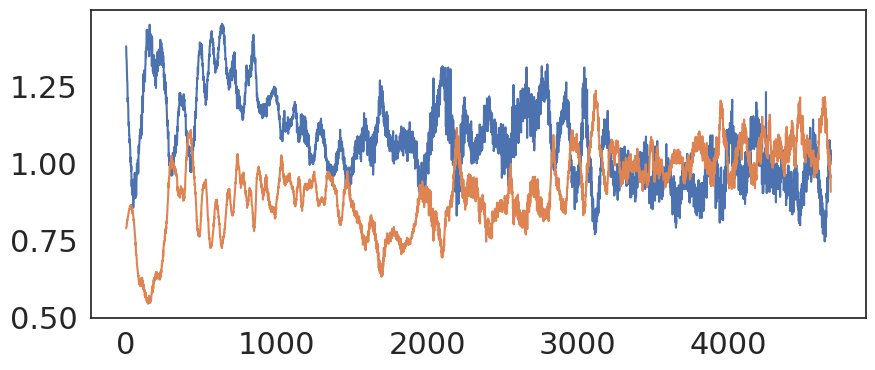

In [104]:
# PLot the training loss for both generator and discriminator
import matplotlib.pyplot as plt

plt.figure(figsize = (10, 4))

plt.plot(disc_train_loss_list)
plt.plot(gen_train_loss_list)

In [105]:
# Function to plot an image
def show_image(img):
    # Convert the image from a tensor to a NumPy array
    npimg = img.numpy()
    # Transpose the NumPy array to the correct format for displaying
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

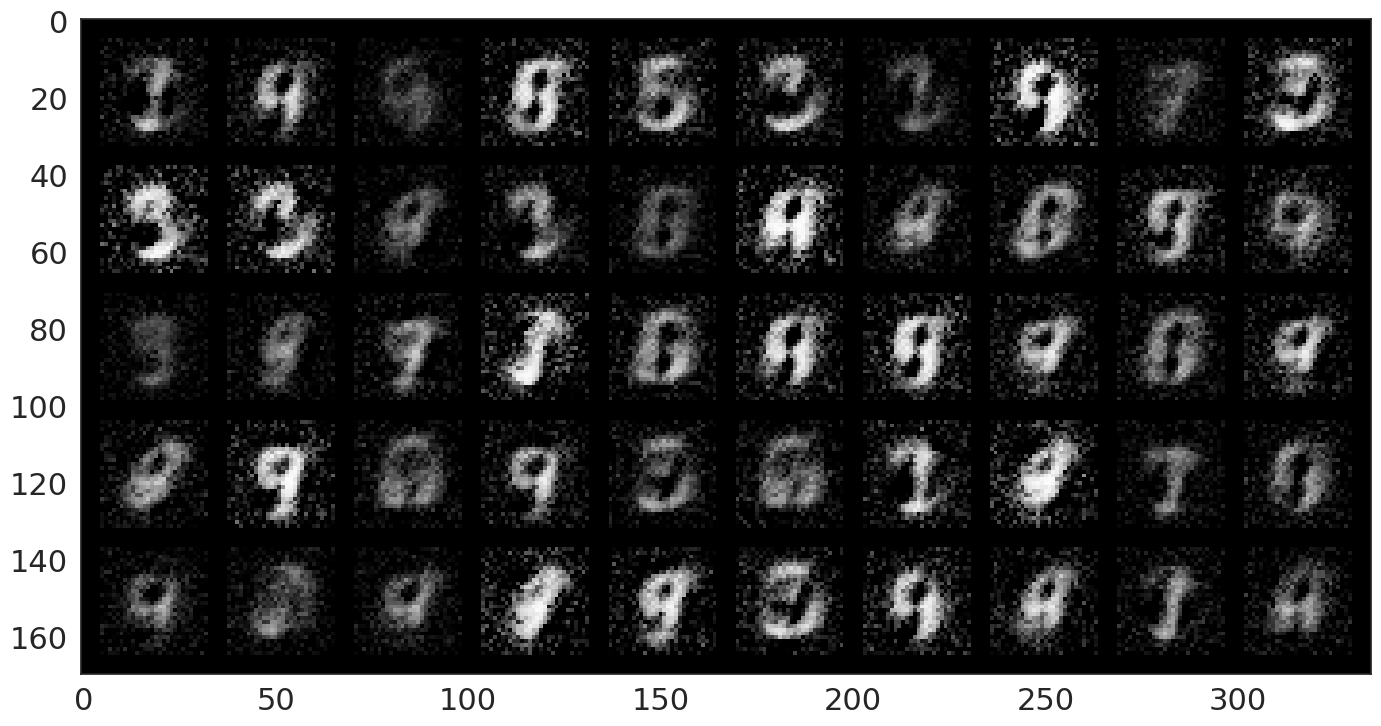

In [106]:
# Plot the first 50 generated samples of trained generator
import torchvision

# Generate random noise for generating fake images
random_noise = torch.randn(128, input_noise_dim, device=device)

with torch.no_grad():

    # Generate fake images from the random noise using the Generator
    fake = gen(random_noise)
    fake = fake.cpu()  # Move the generated fake images to the CPU for displaying

    # Create a Matplotlib figure and axis for displaying the fake images
    fig, ax = plt.subplots(figsize=(20, 8.5))

    # Display the fake images in a grid (e.g., 10x5 grid)
    show_image(torchvision.utils.make_grid(fake[0:50], 10, 5))

    plt.show()

DCGAN

In [122]:
gen_train_loss_list = []
disc_train_loss_list = []

In [142]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm

# DCGAN

class Generator(torch.nn.Module):
    def __init__(self, batchsize, input_noise_dim):
        super(Generator, self).__init__()
        self.model = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(input_noise_dim, 128, kernel_size=7, stride=1, padding=0, bias=False),
            torch.nn.BatchNorm2d(128),
            torch.nn.ReLU(True),
            torch.nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(True),
            torch.nn.ConvTranspose2d(64, 1, kernel_size=4, stride=2, padding=1, bias=False),
            torch.nn.Tanh()
        )

    def forward(self, x):
        x = x.view(x.size(0), x.size(1), 1, 1)
        return self.model(x)

class Discriminator(torch.nn.Module):
    def __init__(self, batchsize):
        super(Discriminator, self).__init__()
        self.model = torch.nn.Sequential(
            torch.nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1, bias=False),
            torch.nn.LeakyReLU(0.2, inplace=True),
            torch.nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
            torch.nn.BatchNorm2d(128),
            torch.nn.LeakyReLU(0.2, inplace=True),
            torch.nn.Conv2d(128, 1, kernel_size=7, stride=1, padding=0, bias=False),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x).view(-1, 1).squeeze(1)


In [146]:
# Fix random seed
torch.manual_seed(55)

# Define learning rate + epochs
learning_rate = 1e-4
epochs = 10
batchsize = 128
input_noise_dim = 100

# Create a Discriminator and Generator model
disc = Discriminator(batchsize)
gen = Generator(batchsize, input_noise_dim)

# Binary Cross Entropy (BCE) loss function
loss_func = nn.BCELoss()
optimizer_disc = optim.Adam(disc.parameters(), lr=learning_rate, weight_decay=1e-05)
optimizer_gen = optim.Adam(gen.parameters(), lr=learning_rate, weight_decay=1e-05)

# Create DataLoader objects to efficiently load the training and test data in batches
train_loader = DataLoader(train_data, batch_size=batchsize, shuffle=True, drop_last=True)

# Set the device as CUDA or CPU based on availability
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Move models to device
disc.to(device)
gen.to(device)





Generator(
  (model): Sequential(
    (0): ConvTranspose2d(100, 128, kernel_size=(7, 7), stride=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): Tanh()
  )
)

In [151]:
discriminator_losses_list = []
generator_losses_list = []

In [155]:
from tqdm import tqdm

for epoch in range(epochs):
    # Wrap DataLoader with tqdm to show progress
    with tqdm(DataLoader(train_data, batch_size=batchsize, shuffle=True), desc=f"Epoch {epoch+1}/{epochs}") as progress_bar:
        for batch_idx, (real_images, _) in enumerate(progress_bar):

            # Move data to the device
            real_images = real_images.to(device)

            # Create noise for the generator
            noise = torch.randn(batchsize, input_noise_dim, device=device)

            # Generate fake images
            fake_images = gen(noise)

            # Train Discriminator

            # Zero out the gradients of the discriminator optimizer
            optimizer_disc.zero_grad()

            # Get discriminator outputs for real and fake images
            disc_real = disc(real_images).view(-1)
            disc_fake = disc(fake_images).view(-1)

            # Calculate discriminator loss
            loss_disc_real = loss_func(disc_real, torch.ones_like(disc_real))
            loss_disc_fake = loss_func(disc_fake, torch.zeros_like(disc_fake))
            disc_loss = (loss_disc_real + loss_disc_fake) / 2

            # Backpropagate the discriminator loss and update weights
            disc_loss.backward(retain_graph=True)
            optimizer_disc.step()

            # Train Generator

            # Zero out the gradients of the generator optimizer
            optimizer_gen.zero_grad()

            # Get discriminator output for fake images (again)
            disc_fake = disc(fake_images).view(-1)

            # Calculate generator loss
            gen_loss = loss_func(disc_fake, torch.ones_like(disc_fake))

            # Backpropagate the generator loss and update weights
            gen_loss.backward()
            optimizer_gen.step()

            # Track losses
            discriminator_losses_list.append(disc_loss.item())
            generator_losses_list.append(gen_loss.item())

            # Update the tqdm progress bar description with loss info
            # progress_bar.set_postfix(D_loss=disc_loss.item(), G_loss=gen_loss.item())

            progress_bar.set_postfix(D_loss=disc_loss.item(), G_loss=gen_loss.item())


Epoch 10/10: 100%|██████████| 469/469 [00:16<00:00, 28.47it/s, D_loss=0.00228, G_loss=7.75]


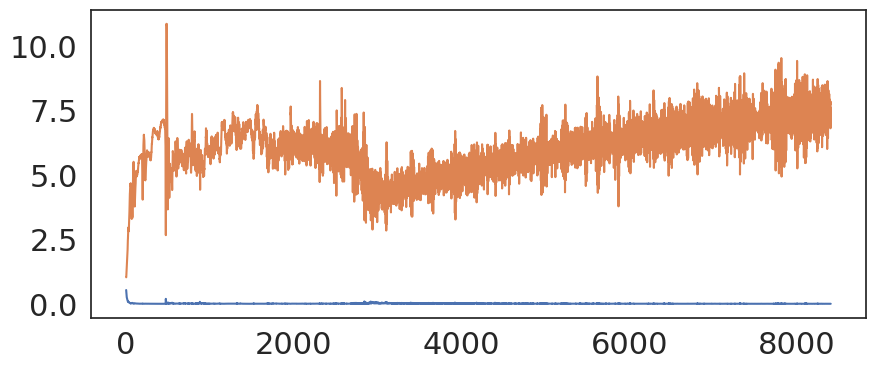

In [161]:
# PLot the training loss for both generator and discriminator
import matplotlib.pyplot as plt

plt.figure(figsize = (10, 4))

# plt.plot(discriminator_losses_list, label='Discriminator Loss')
# plt.plot(generator_losses_list, label='Generator Loss')
plt.plot(discriminator_losses_list)
plt.plot(generator_losses_list)
# plt.legend()
plt.show()

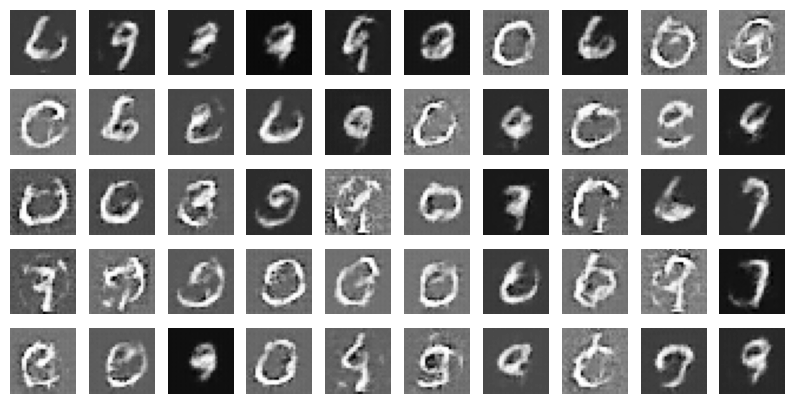

In [156]:
# Plot the first 50 generated samples of trained generator
# YOUR CODE HERE
plt.figure(figsize=(10, 5))
for i in range(50):
    plt.subplot(5, 10, i+1)
    # Squeeze the dimensions to get a 2D array
    image = gen(torch.randn(1, input_noise_dim, device=device)).detach().cpu().squeeze(0)
    # Remove the first dimension of the image array if the image is grayscale
    image = image.squeeze() if image.dim() == 3 else image
    plt.imshow(image, cmap='gray')  # Display the image
    plt.axis('off')

### Briefly describe your experience of using DCGAN vs Vanilla-GAN

DCGANs are generally considered an enhancement over traditional Vanilla GANs, particularly in the context of image generation. The key improvement of DCGANs lies in the use of convolutional layers in both the generator and discriminator networks, which provide a more stable training process and improve the model's ability to capture spatial patterns in images. Convolutional layers are well-suited for working with image data, as they preserve spatial hierarchies and local dependencies, which are essential for generating high-quality images. By leveraging these spatial relationships, DCGANs are better equipped to understand complex textures and structures within images, leading to the generation of more realistic and visually coherent outputs. This makes DCGANs highly effective for tasks requiring high-quality image generation, such as in computer vision and artistic content creation, where visual fidelity is critical.